In [1]:
import tensorflow as tf
print(tf.__version__)

2023-12-01 03:23:34.521883: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2023-12-01 03:23:34.521924: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2023-12-01 03:23:34.521955: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-12-01 03:23:34.531296: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


2.14.0


In [ ]:
#!apt-get update

# 데이터 준비

In [2]:
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.cifar10.load_data()

print('train data')
print(x_train.shape)
print(y_train.shape)

print('test data')
print(x_test.shape)
print(y_test.shape)

train data
(50000, 32, 32, 3)
(50000, 1)
test data
(10000, 32, 32, 3)
(10000, 1)


In [3]:
# 데이터 전처리: 정규화
x_train, x_test = x_train / 255.0,  x_test / 255.0

In [4]:
# scalar 형태의 레이블(0-9)을 one-hot encoding 형태로 변환합니다

y_train = tf.squeeze(tf.one_hot(y_train, 10),axis=1)
y_test = tf.squeeze(tf.one_hot(y_test, 10), axis=1)

print('train data')
print(x_train.shape)
print(y_train.shape)

print('test data')
print(x_test.shape)
print(y_test.shape)

train data
(50000, 32, 32, 3)
(50000, 10)
test data
(10000, 32, 32, 3)
(10000, 10)


2023-12-01 03:23:44.195084: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1886] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 18452 MB memory:  -> device: 0, name: NVIDIA RTX 4000 SFF Ada Generation, pci bus id: 0000:0c:00.0, compute capability: 8.9


# 모델 로드

In [5]:
#from google.colab import drive
#drive.mount('/content/drive')

In [6]:
from tensorflow.keras.models import load_model

best_vgg16 = load_model("./best_model.h5")

In [7]:
best_vgg16.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 32, 32, 3)]       0         
                                                                 
 block1_conv1 (Conv2D)       (None, 32, 32, 64)        1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 32, 32, 64)        36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 16, 16, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 16, 16, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 16, 16, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 8, 8, 128)         0   

# inference time

In [8]:
# 평가
best_vgg16.evaluate(x_test, y_test)

2023-12-01 03:23:46.270129: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:442] Loaded cuDNN version 8905
2023-12-01 03:23:46.395304: I tensorflow/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory


  9/313 [..............................] - ETA: 2s - loss: 0.5923 - accuracy: 0.8472  

2023-12-01 03:23:46.828156: I tensorflow/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory


313/313 [==============================] - 3s 7ms/step - loss: 0.5326 - accuracy: 0.8536


[0.5325802564620972, 0.853600025177002]

## 가중치 추출

In [9]:
import numpy as np
import tensorflow as tf

#모델의 각 레이어를 순회하며 파라미터 수를 계산
for layer in best_vgg16.layers:
    trainable_count = np.sum([tf.size(w).numpy() for w in layer.trainable_weights])
    non_trainable_count = np.sum([tf.size(w).numpy() for w in layer.non_trainable_weights])

    print(f"Layer: {layer.name}")
    print(f"  Trainable parameters: {trainable_count}")
    print(f"  Non-trainable parameters: {non_trainable_count}")

Layer: input_3
  Trainable parameters: 0.0
  Non-trainable parameters: 0.0
Layer: block1_conv1
  Trainable parameters: 1792
  Non-trainable parameters: 0.0
Layer: block1_conv2
  Trainable parameters: 36928
  Non-trainable parameters: 0.0
Layer: block1_pool
  Trainable parameters: 0.0
  Non-trainable parameters: 0.0
Layer: block2_conv1
  Trainable parameters: 73856
  Non-trainable parameters: 0.0
Layer: block2_conv2
  Trainable parameters: 147584
  Non-trainable parameters: 0.0
Layer: block2_pool
  Trainable parameters: 0.0
  Non-trainable parameters: 0.0
Layer: block3_conv1
  Trainable parameters: 295168
  Non-trainable parameters: 0.0
Layer: block3_conv2
  Trainable parameters: 590080
  Non-trainable parameters: 0.0
Layer: block3_conv3
  Trainable parameters: 590080
  Non-trainable parameters: 0.0
Layer: block3_pool
  Trainable parameters: 0.0
  Non-trainable parameters: 0.0
Layer: block4_conv1
  Trainable parameters: 1180160
  Non-trainable parameters: 0.0
Layer: block4_conv2
  Train

# [Code] LoRA

아래의 lora 코드에는 scheduling factor와 noise가 포함되어 있다.

## ConvLoRA

In [10]:
import tensorflow as tf
from tensorflow.keras import layers, initializers
from tensorflow.keras.layers import Conv2D, Conv1D, Conv3D

class ConvLoRALayer00_cdn2(layers.Layer):
    def __init__(
        self,
        original_conv_layer,
        total_iteration = 1000 ,  # Total number of iterations for the decay
        start_percent=0.1,  # The percentage of total_iteration when decay starts
        end_percent=0.9,  # The percentage of total_iteration when decay ends
        min_decay_factor=0,  # The minimum value that decay factor can take
        rank=32,
        alpha=32,
        trainable=True,
        **kwargs
    ):
        # Capture the original layer's configuration.
        original_layer_config = original_conv_layer.get_config()
        name = original_layer_config["name"]
        kwargs.pop("name", None)

        super().__init__(name=name, trainable=trainable, **kwargs)

        self.rank = rank
        self.alpha = alpha
        self._scale = alpha / rank

        # The original convolutional layer is set to non-trainable to freeze its weights.
        self.original_conv_layer = original_conv_layer
        self.original_conv_layer.trainable = False

        self.kernel = None
        self.filters = original_conv_layer.filters #
        self.kernel_size = original_conv_layer.kernel_size[0] #
        self.in_channels = None

        self.total_iteration = total_iteration
        self.start_step = int(total_iteration * start_percent)
        self.end_step = int(total_iteration * end_percent)
        self.min_decay_factor = min_decay_factor

        #trainable=False, 이 변수가 텐서플로우의 자동 미분 및 최적화 과정에 의해 업데이트되지 않는다는 뜻
        #수동으로 업데이트될 수 있습니다. 예를 들어, 반복문 안에서 이 변수의 값을 업데이트하는 로직을 작성할 수 있음!
        self.current_step = tf.Variable(0, dtype=tf.int32, trainable=False)
        self.decay_factor = tf.Variable(1.0, dtype=tf.float32, trainable=False)

    def build(self, input_shape):
        # Ensure the original convolutional layer is built.
        #if not self.original_conv_layer.built:
        #    self.original_conv_layer.build(input_shape)

        # Calculate the shape for LoRA weights A and B.
        #self.kernel = self.original_conv_layer.kernel
        self.in_channels = input_shape[-1]

        in_channels = self.in_channels
        out_channels = self.filters
        kernel_size = self.original_conv_layer.kernel_size[0]

        # LoRA weights A and B.
        self.A_weight = self.add_weight(
            name="lora_A_weight",
            shape=(self.rank*kernel_size, in_channels*kernel_size),
            initializer=initializers.VarianceScaling(scale=1.0, mode='fan_in', distribution='uniform'),
            trainable=self.trainable
        )

        self.B_weight = self.add_weight(
            name="lora_B_weight",
            shape=(out_channels*kernel_size, self.rank*kernel_size),
            initializer="zeros",
            trainable=self.trainable
        )

        super().build(input_shape)


    def call(self, inputs, training=None):
        if training is None:
                training = self.trainable

        # Calculate the linear decay factor
        if self.current_step < self.start_step:
            self.decay_factor.assign(1.0)  # Decay has not started yet
        elif self.current_step > self.end_step:
            self.decay_factor.assign(tf.cast(self.min_decay_factor, dtype=tf.float32))  # Ensure float32 type for consistency
        else:
            # Linear decay between start_step and end_step
            self.decay_factor.assign(1.0 - ((tf.cast(self.current_step, dtype=tf.float32) - self.start_step) /
                                    (self.end_step - self.start_step) *
                                    (1.0 - tf.cast(self.min_decay_factor, dtype=tf.float32))))

        lora_BA = (self.B_weight@self.A_weight)

        kernel_size = self.original_conv_layer.kernel_size[0]
        in_channels = self.in_channels
        out_channels = self.filters

           # lora_BA의 형태 변환
           # lora_BA가 (out_channels*kernel_size*kernel_size, in_channels*kernel_size*kernel_size) 형태라고 가정
           # 이를 (kernel_size, kernel_size, in_channels, out_channels)로 변환
        lora_BA_reshaped = tf.reshape(lora_BA, (out_channels, kernel_size, kernel_size, in_channels))
        lora_BA_reshaped = tf.transpose(lora_BA_reshaped, [1, 2, 3, 0])
        lora_output = tf.nn.conv2d(inputs, lora_BA_reshaped, strides=[1, 1, 1, 1], padding='SAME') * self._scale

        # original_output = self.original_conv_layer(inputs) * self.decay_factor

        if training:
            original_output = self.original_conv_layer(inputs)
            # 평균과 표준편차 계산
            original_weight_matrix = self.original_conv_layer.weights[0]
            original_mean = tf.reduce_mean(original_weight_matrix)
            original_variance = tf.reduce_mean(tf.square(original_weight_matrix - original_mean))
            original_stddev = tf.sqrt(original_variance)

            # decay_factor가 0.3보다 작으면 noise_mean과 noise_std를 0으로 설정
            noise_mean = tf.where(self.decay_factor < 0.3, 0.0, original_mean * (1 - self.decay_factor))
            noise_std = tf.where(self.decay_factor < 0.3, 0.0, original_stddev * tf.sqrt(1 - tf.square(self.decay_factor)))
            noise = tf.random.normal(tf.shape(original_weight_matrix), mean=noise_mean, stddev=noise_std)
            noise_output = tf.nn.conv2d(inputs, noise, strides=[1, 1, 1, 1], padding='SAME')

            self.current_step.assign_add(1)

            return original_output * self.decay_factor + lora_output

        else:
            # 추론 모드에서는 LoRA 출력만 반환
            return lora_output

## DenseLoRA

In [11]:
import math
from tensorflow import keras

class LoraLayer(keras.layers.Layer):
    def __init__(
        self,
        original_layer,
        total_iteration = 1000 ,  # Total number of iterations for the decay
        start_percent=0.1,  # The percentage of total_iteration when decay starts
        end_percent=0.9,  # The percentage of total_iteration when decay ends
        min_decay_factor=0,  # The minimum value that decay factor can take
        rank=32,
        alpha=32,
        trainable=True,
        **kwargs,
    ):
        original_layer_config = original_layer.get_config()
        name = original_layer_config["name"]
        kwargs.pop("name", None)

        super().__init__(name=name, trainable=trainable, **kwargs)

        self.rank = rank
        self.alpha = alpha
        self._scale = alpha / rank

        self.original_layer = original_layer
        self.original_layer.trainable = False


        self.total_iteration = total_iteration
        self.start_step = int(total_iteration * start_percent)
        self.end_step = int(total_iteration * end_percent)
        self.min_decay_factor = min_decay_factor

        #trainable=False, 이 변수가 텐서플로우의 자동 미분 및 최적화 과정에 의해 업데이트되지 않는다는 뜻
        #수동으로 업데이트될 수 있습니다. 예를 들어, 반복문 안에서 이 변수의 값을 업데이트하는 로직을 작성할 수 있음!
        self.current_step = tf.Variable(0, dtype=tf.int32, trainable=False)
        self.decay_factor = tf.Variable(1.0, dtype=tf.float32, trainable=False)

    def build(self, input_shape):
        # LoRA weights.
        kernel_shape = self.original_layer.kernel.shape
        self.A_weight = self.add_weight(
            name="lora_A_weight",
            shape=(self.rank, kernel_shape[0]),
            initializer=keras.initializers.VarianceScaling(
                scale=math.sqrt(5), mode="fan_in", distribution="uniform"
            ),
            trainable=self.trainable,
        )

        self.B_weight = self.add_weight(
            name="lora_B_weight",
            shape=(self.original_layer.units, self.rank),
            initializer='zeros',
            trainable=self.trainable,
        )

        super().build(input_shape)

    def call(self, inputs, training=None):
            if training is None:
                training = self.trainable

            # Calculate the linear decay factor
            if self.current_step < self.start_step:
                self.decay_factor.assign(1.0)  # Decay has not started yet
            elif self.current_step > self.end_step:
                self.decay_factor.assign(tf.cast(self.min_decay_factor, dtype=tf.float32))  # Ensure float32 type for consistency
            else:
                # Linear decay between start_step and end_step
                self.decay_factor.assign(1.0 - ((tf.cast(self.current_step, dtype=tf.float32) - self.start_step) /
                                        (self.end_step - self.start_step) *
                                        (1.0 - tf.cast(self.min_decay_factor, dtype=tf.float32))))

            # Matrix multiplication for A and B weights with inputs
            lora_A_output = tf.matmul(self.A_weight, tf.transpose(inputs))  # Ax
            lora_output = tf.transpose(tf.matmul(self.B_weight, lora_A_output) * self._scale)  # BAx Transpose back to [batch_size, original_layer.units]

            #lora_output *= (1 - self.decay_factor) # 멘토링 때 나온 의견

            if training:
                original_output = self.original_layer(inputs)
                # 평균과 표준편차 계산
                original_weight_matrix = self.original_layer.weights[0]
                original_mean = tf.reduce_mean(original_weight_matrix, axis=0)
                original_variance = tf.reduce_mean(tf.square(original_weight_matrix - original_mean), axis=0)
                original_stddev = tf.sqrt(original_variance)

                # decay_factor가 0.3보다 작으면 noise_mean과 noise_std를 0으로 설정
                noise_mean = tf.where(self.decay_factor < 0.3, 0.0, original_mean * (1 - self.decay_factor))
                noise_std = tf.where(self.decay_factor < 0.3, 0.0, original_stddev * tf.sqrt(1 - tf.square(self.decay_factor)))
                noise = tf.random.normal(tf.shape(original_weight_matrix), mean=noise_mean, stddev=noise_std)

                self.current_step.assign_add(1)

                return original_output * self.decay_factor + lora_output

            else:
                # 추론 모드에서는 LoRA 출력만 반환
                return lora_output


# LoRA 적용. Exp1: Convlora + Denselayer는 ❄

## 1-1. (16, -)

In [13]:
dataset_size = x_train.shape[0]
batch_size = 30
epochs = 20

total_iteration= int(epochs * (dataset_size / batch_size))

In [14]:
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Flatten, Dense, Dropout, InputLayer
import tensorflow as tf

# 새로운 레이어를 추가하기 위한 레이어 리스트 초기화
new_layers = []

# VGG 모델의 각 레이어 순회
for layer in best_vgg16.layers:
    if isinstance(layer, InputLayer):
        continue

    if isinstance(layer, Conv2D):
        # Conv2D 레이어를 ConvLoRALayer로 대체
        conv_lora_layer = ConvLoRALayer00_cdn2(original_conv_layer=layer, rank=16, alpha=32, total_iteration = total_iteration, trainable=True)
        new_layers.append(conv_lora_layer)

    else:
        # 다른 유형의 레이어는 그대로 유지
        new_layers.append(layer)

# 새로운 입력 텐서 생성
input_tensor = best_vgg16.input

# 새로운 모델 구성
x = input_tensor
for layer in new_layers:
    x = layer(x)

# 새로운 모델 생성
lora_vgg161 = Model(inputs=input_tensor, outputs=x)

In [15]:
from tensorflow.keras.layers import Conv2D

# 새로 생성된 모델에서 Dense 레이어 중 LoRA가 적용되지 않은 레이어의 trainable을 False로 설정
for layer in lora_vgg161.layers:
    if isinstance(layer, Dense):
        layer.trainable = False

In [16]:
lora_vgg161.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 32, 32, 3)]       0         
                                                                 
 block1_conv1 (ConvLoRALaye  (None, 32, 32, 64)        11442     
 r00_cdn2)                                                       
                                                                 
 block1_conv2 (ConvLoRALaye  (None, 32, 32, 64)        55362     
 r00_cdn2)                                                       
                                                                 
 block1_pool (MaxPooling2D)  (None, 16, 16, 64)        0         
                                                                 
 block2_conv1 (ConvLoRALaye  (None, 16, 16, 128)       101506    
 r00_cdn2)                                                       
                                                             

## 가중치 추출

In [17]:
import numpy as np
import tensorflow as tf

#모델의 각 레이어를 순회하며 파라미터 수를 계산
for layer in lora_vgg161.layers:
    trainable_count = np.sum([tf.size(w).numpy() for w in layer.trainable_weights])
    non_trainable_count = np.sum([tf.size(w).numpy() for w in layer.non_trainable_weights])

    print(f"Layer: {layer.name}")
    print(f"  Trainable parameters: {trainable_count}")
    print(f"  Non-trainable parameters: {non_trainable_count}")

Layer: input_3
  Trainable parameters: 0.0
  Non-trainable parameters: 0.0
Layer: block1_conv1
  Trainable parameters: 9648
  Non-trainable parameters: 1794
Layer: block1_conv2
  Trainable parameters: 18432
  Non-trainable parameters: 36930
Layer: block1_pool
  Trainable parameters: 0.0
  Non-trainable parameters: 0.0
Layer: block2_conv1
  Trainable parameters: 27648
  Non-trainable parameters: 73858
Layer: block2_conv2
  Trainable parameters: 36864
  Non-trainable parameters: 147586
Layer: block2_pool
  Trainable parameters: 0.0
  Non-trainable parameters: 0.0
Layer: block3_conv1
  Trainable parameters: 55296
  Non-trainable parameters: 295170
Layer: block3_conv2
  Trainable parameters: 73728
  Non-trainable parameters: 590082
Layer: block3_conv3
  Trainable parameters: 73728
  Non-trainable parameters: 590082
Layer: block3_pool
  Trainable parameters: 0.0
  Non-trainable parameters: 0.0
Layer: block4_conv1
  Trainable parameters: 110592
  Non-trainable parameters: 1180162
Layer: bloc

## 스케줄링 및 노이즈

In [18]:
lora_layers = []  # lora 레이어들을 저장할 리스트

for layer in lora_vgg161.layers:
    if isinstance(layer, ConvLoRALayer00_cdn2) or isinstance(layer, LoraLayer):
        lora_layers.append(layer)

In [19]:
from tensorflow import keras

class PrintCurrentStepCallback(keras.callbacks.Callback):
    def __init__(self, lora_layers):
        super().__init__()
        self.lora_layers = lora_layers

    def on_epoch_end(self, epoch, logs=None):
        print()
        for i, lora_layer in enumerate(self.lora_layers):
            current_step = lora_layer.current_step.value()
            decay_factor = lora_layer.decay_factor.value()
            print(f"End of epoch {epoch + 1}, LoraLayer {i}: {current_step} Step")
            print(f"End of epoch {epoch + 1}, LoraLayer {i}: Decay factor: {decay_factor}")

In [20]:
# 콜백 생성 시 lora_layers 딕셔너리의 값만 사용
print_step_callback = PrintCurrentStepCallback(lora_layers)

In [21]:
class TestCallback(keras.callbacks.Callback):
    def __init__(self, test_data):
        self.test_data = test_data

    def on_epoch_end(self, epoch, logs={}):
        x, y = self.test_data
        loss, acc = self.model.evaluate(x, y, verbose=0)
        print('\nTesting loss: {}, acc: {}\n'.format(loss, acc))

##학습

In [22]:
from tensorflow.keras.optimizers import Adam

# 모델 컴파일
lora_vgg161.compile(optimizer=Adam(learning_rate=0.0001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [23]:
lora_vgg161.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 32, 32, 3)]       0         
                                                                 
 block1_conv1 (ConvLoRALaye  (None, 32, 32, 64)        11442     
 r00_cdn2)                                                       
                                                                 
 block1_conv2 (ConvLoRALaye  (None, 32, 32, 64)        55362     
 r00_cdn2)                                                       
                                                                 
 block1_pool (MaxPooling2D)  (None, 16, 16, 64)        0         
                                                                 
 block2_conv1 (ConvLoRALaye  (None, 16, 16, 128)       101506    
 r00_cdn2)                                                       
                                                             

In [24]:
history32 = lora_vgg161.fit(x_train, y_train, batch_size=30, epochs=20, validation_data=(x_test, y_test), callbacks=[print_step_callback, TestCallback((x_test, y_test))] )

Epoch 1/20


2023-12-01 01:58:08.760619: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x7f4229333bc0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2023-12-01 01:58:08.760659: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA RTX 4000 SFF Ada Generation, Compute Capability 8.9
2023-12-01 01:58:08.767940: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2023-12-01 01:58:08.945955: I ./tensorflow/compiler/jit/device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


1667/1667 [==============================] - ETA: 0s - loss: 0.2204 - accuracy: 0.9309
End of epoch 1, LoraLayer 0: 1667 Step
End of epoch 1, LoraLayer 0: Decay factor: 1.0
End of epoch 1, LoraLayer 1: 1667 Step
End of epoch 1, LoraLayer 1: Decay factor: 1.0
End of epoch 1, LoraLayer 2: 1667 Step
End of epoch 1, LoraLayer 2: Decay factor: 1.0
End of epoch 1, LoraLayer 3: 1667 Step
End of epoch 1, LoraLayer 3: Decay factor: 1.0
End of epoch 1, LoraLayer 4: 1667 Step
End of epoch 1, LoraLayer 4: Decay factor: 1.0
End of epoch 1, LoraLayer 5: 1667 Step
End of epoch 1, LoraLayer 5: Decay factor: 1.0
End of epoch 1, LoraLayer 6: 1667 Step
End of epoch 1, LoraLayer 6: Decay factor: 1.0
End of epoch 1, LoraLayer 7: 1667 Step
End of epoch 1, LoraLayer 7: Decay factor: 1.0
End of epoch 1, LoraLayer 8: 1667 Step
End of epoch 1, LoraLayer 8: Decay factor: 1.0
End of epoch 1, LoraLayer 9: 1667 Step
End of epoch 1, LoraLayer 9: Decay factor: 1.0
End of epoch 1, LoraLayer 10: 1667 Step
End of epoch 

## inference time

In [25]:
# 평가
lora_vgg161.evaluate(x_test, y_test)

313/313 [==============================] - 3s 8ms/step - loss: 0.8240 - accuracy: 0.7273


[0.8239779472351074, 0.7272999882698059]

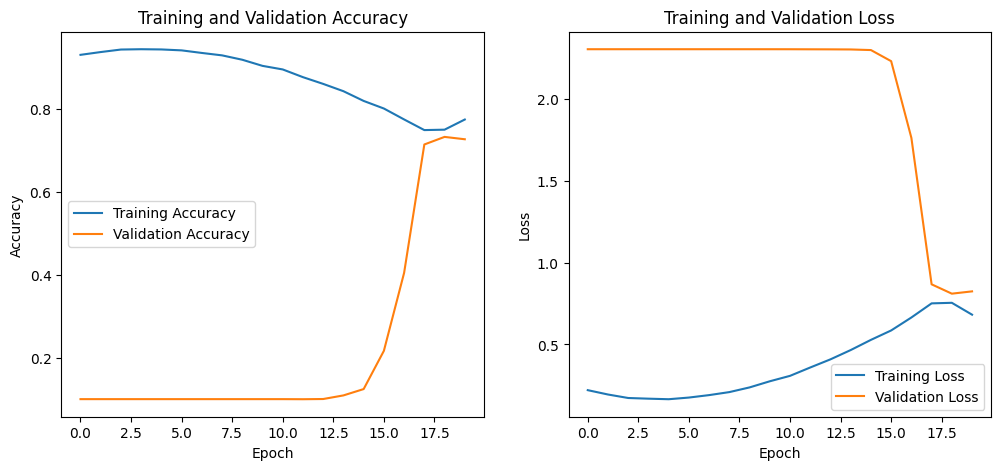

In [26]:
import matplotlib.pyplot as plt

# 학습 및 검증 정확도 시각화
plt.figure(figsize=(12, 5))

# 정확도 그래프
plt.subplot(1, 2, 1)
plt.plot(history32.history['accuracy'], label='Training Accuracy')
plt.plot(history32.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# 손실 그래프
plt.subplot(1, 2, 2)
plt.plot(history32.history['loss'], label='Training Loss')
plt.plot(history32.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.show()

## 1-2. (32, -)

In [27]:
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Flatten, Dense, Dropout, InputLayer
import tensorflow as tf

# 새로운 레이어를 추가하기 위한 레이어 리스트 초기화
new_layers = []

# VGG 모델의 각 레이어 순회
for layer in best_vgg16.layers:
    if isinstance(layer, InputLayer):
        continue

    if isinstance(layer, Conv2D):
        # Conv2D 레이어를 ConvLoRALayer로 대체
        conv_lora_layer = ConvLoRALayer00_cdn2(original_conv_layer=layer, rank=32, alpha=32, total_iteration = total_iteration, trainable=True)
        new_layers.append(conv_lora_layer)

    else:
        # 다른 유형의 레이어는 그대로 유지
        new_layers.append(layer)

# 새로운 입력 텐서 생성
input_tensor = best_vgg16.input

# 새로운 모델 구성
x = input_tensor
for layer in new_layers:
    x = layer(x)

# 새로운 모델 생성
lora_vgg162 = Model(inputs=input_tensor, outputs=x)

In [28]:
from tensorflow.keras.layers import Conv2D

# 새로 생성된 모델에서 Dense 레이어 중 LoRA가 적용되지 않은 레이어의 trainable을 False로 설정
for layer in lora_vgg162.layers:
    if isinstance(layer, Dense):
        layer.trainable = False

In [29]:
lora_vgg162.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 32, 32, 3)]       0         
                                                                 
 block1_conv1 (ConvLoRALaye  (None, 32, 32, 64)        21090     
 r00_cdn2)                                                       
                                                                 
 block1_conv2 (ConvLoRALaye  (None, 32, 32, 64)        73794     
 r00_cdn2)                                                       
                                                                 
 block1_pool (MaxPooling2D)  (None, 16, 16, 64)        0         
                                                                 
 block2_conv1 (ConvLoRALaye  (None, 16, 16, 128)       129154    
 r00_cdn2)                                                       
                                                           

In [30]:
import numpy as np
import tensorflow as tf

#모델의 각 레이어를 순회하며 파라미터 수를 계산
for layer in lora_vgg162.layers:
    trainable_count = np.sum([tf.size(w).numpy() for w in layer.trainable_weights])
    non_trainable_count = np.sum([tf.size(w).numpy() for w in layer.non_trainable_weights])

    print(f"Layer: {layer.name}")
    print(f"  Trainable parameters: {trainable_count}")
    print(f"  Non-trainable parameters: {non_trainable_count}")

Layer: input_3
  Trainable parameters: 0.0
  Non-trainable parameters: 0.0
Layer: block1_conv1
  Trainable parameters: 19296
  Non-trainable parameters: 1794
Layer: block1_conv2
  Trainable parameters: 36864
  Non-trainable parameters: 36930
Layer: block1_pool
  Trainable parameters: 0.0
  Non-trainable parameters: 0.0
Layer: block2_conv1
  Trainable parameters: 55296
  Non-trainable parameters: 73858
Layer: block2_conv2
  Trainable parameters: 73728
  Non-trainable parameters: 147586
Layer: block2_pool
  Trainable parameters: 0.0
  Non-trainable parameters: 0.0
Layer: block3_conv1
  Trainable parameters: 110592
  Non-trainable parameters: 295170
Layer: block3_conv2
  Trainable parameters: 147456
  Non-trainable parameters: 590082
Layer: block3_conv3
  Trainable parameters: 147456
  Non-trainable parameters: 590082
Layer: block3_pool
  Trainable parameters: 0.0
  Non-trainable parameters: 0.0
Layer: block4_conv1
  Trainable parameters: 221184
  Non-trainable parameters: 1180162
Layer: 

In [31]:
lora_layers = []  # lora 레이어들을 저장할 리스트

for layer in lora_vgg162.layers:
    if isinstance(layer, ConvLoRALayer00_cdn2) or isinstance(layer, LoraLayer):
        lora_layers.append(layer)

In [32]:
from tensorflow import keras

class PrintCurrentStepCallback(keras.callbacks.Callback):
    def __init__(self, lora_layers):
        super().__init__()
        self.lora_layers = lora_layers

    def on_epoch_end(self, epoch, logs=None):
        print()
        for i, lora_layer in enumerate(self.lora_layers):
            current_step = lora_layer.current_step.value()
            decay_factor = lora_layer.decay_factor.value()
            print(f"End of epoch {epoch + 1}, LoraLayer {i}: {current_step} Step")
            print(f"End of epoch {epoch + 1}, LoraLayer {i}: Decay factor: {decay_factor}")

In [33]:
# 콜백 생성 시 lora_layers 딕셔너리의 값만 사용
print_step_callback = PrintCurrentStepCallback(lora_layers)

In [34]:
class TestCallback(keras.callbacks.Callback):
    def __init__(self, test_data):
        self.test_data = test_data

    def on_epoch_end(self, epoch, logs={}):
        x, y = self.test_data
        loss, acc = self.model.evaluate(x, y, verbose=0)
        print('\nTesting loss: {}, acc: {}\n'.format(loss, acc))

##학습

In [35]:
from tensorflow.keras.optimizers import Adam

# 모델 컴파일
lora_vgg162.compile(optimizer=Adam(learning_rate=0.0001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [36]:
lora_vgg162.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 32, 32, 3)]       0         
                                                                 
 block1_conv1 (ConvLoRALaye  (None, 32, 32, 64)        21090     
 r00_cdn2)                                                       
                                                                 
 block1_conv2 (ConvLoRALaye  (None, 32, 32, 64)        73794     
 r00_cdn2)                                                       
                                                                 
 block1_pool (MaxPooling2D)  (None, 16, 16, 64)        0         
                                                                 
 block2_conv1 (ConvLoRALaye  (None, 16, 16, 128)       129154    
 r00_cdn2)                                                       
                                                           

In [37]:
history33 = lora_vgg162.fit(x_train, y_train, batch_size=30, epochs=20, validation_data=(x_test, y_test), callbacks=[print_step_callback, TestCallback((x_test, y_test))] )

Epoch 1/20
1667/1667 [==============================] - ETA: 0s - loss: 0.1455 - accuracy: 0.9529
End of epoch 1, LoraLayer 0: 1667 Step
End of epoch 1, LoraLayer 0: Decay factor: 1.0
End of epoch 1, LoraLayer 1: 1667 Step
End of epoch 1, LoraLayer 1: Decay factor: 1.0
End of epoch 1, LoraLayer 2: 1667 Step
End of epoch 1, LoraLayer 2: Decay factor: 1.0
End of epoch 1, LoraLayer 3: 1667 Step
End of epoch 1, LoraLayer 3: Decay factor: 1.0
End of epoch 1, LoraLayer 4: 1667 Step
End of epoch 1, LoraLayer 4: Decay factor: 1.0
End of epoch 1, LoraLayer 5: 1667 Step
End of epoch 1, LoraLayer 5: Decay factor: 1.0
End of epoch 1, LoraLayer 6: 1667 Step
End of epoch 1, LoraLayer 6: Decay factor: 1.0
End of epoch 1, LoraLayer 7: 1667 Step
End of epoch 1, LoraLayer 7: Decay factor: 1.0
End of epoch 1, LoraLayer 8: 1667 Step
End of epoch 1, LoraLayer 8: Decay factor: 1.0
End of epoch 1, LoraLayer 9: 1667 Step
End of epoch 1, LoraLayer 9: Decay factor: 1.0
End of epoch 1, LoraLayer 10: 1667 Step
En

In [38]:
# 평가
lora_vgg162.evaluate(x_test, y_test)

313/313 [==============================] - 3s 10ms/step - loss: 0.7557 - accuracy: 0.7656


[0.7557053565979004, 0.7656000256538391]

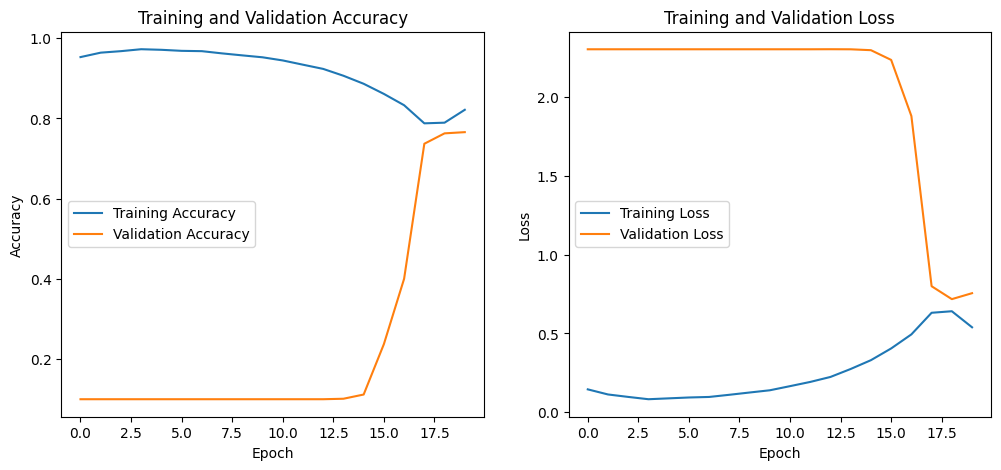

In [39]:
import matplotlib.pyplot as plt

# 학습 및 검증 정확도 시각화
plt.figure(figsize=(12, 5))

# 정확도 그래프
plt.subplot(1, 2, 1)
plt.plot(history33.history['accuracy'], label='Training Accuracy')
plt.plot(history33.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# 손실 그래프
plt.subplot(1, 2, 2)
plt.plot(history33.history['loss'], label='Training Loss')
plt.plot(history33.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.show()

---
#Experiments 2 : 모든 Convlora + dense6,7에 denselora + dense8 ❄

## 2-1. (32, 32)

In [12]:
dataset_size = x_train.shape[0]
batch_size = 30
epochs = 20

total_iteration= int(epochs * (dataset_size / batch_size))

In [13]:
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Flatten, Dense, Dropout, InputLayer
import tensorflow as tf

# 새로운 레이어를 추가하기 위한 레이어 리스트 초기화
new_layers = []

# Dense 레이어 카운터
dense_layer_count = 0

# VGG 모델의 각 레이어 순회
for layer in best_vgg16.layers:
    if isinstance(layer, InputLayer):
        continue
    if isinstance(layer, Conv2D):
        # Conv2D 레이어를 ConvLoRALayer로 대체
        conv_lora_layer = ConvLoRALayer00_cdn2(original_conv_layer=layer, rank=32, alpha=32, total_iteration = total_iteration, trainable=True)
        new_layers.append(conv_lora_layer)
    elif isinstance(layer, Dense):
        dense_layer_count += 1
        # 첫 번째와 두 번째 Dense 레이어에만 LoraLayer 적용
        if dense_layer_count in [1, 2]:
            dense_lora_layer = LoraLayer(original_layer=layer, rank=32, alpha=32, total_iteration=total_iteration, trainable=True)
            new_layers.append(dense_lora_layer)
        else:
            new_layers.append(layer)  # 그대로 유지함
    else:
        # 다른 유형의 레이어는 그대로 유지
        new_layers.append(layer)

# 새로운 입력 텐서 생성
input_tensor = best_vgg16.input

# 새로운 모델 구성
x = input_tensor
for layer in new_layers:
    x = layer(x)

# 새로운 모델 생성
exp21_lora_vgg16 = Model(inputs=input_tensor, outputs=x)

In [14]:
from tensorflow.keras.layers import Conv2D

# 새로 생성된 모델에서 Dense 레이어 중 LoRA가 적용되지 않은 레이어의 trainable을 False로 설정
for layer in exp21_lora_vgg16.layers:
    if isinstance(layer, Dense) and not isinstance(layer, LoraLayer):
        layer.trainable = False

In [15]:
exp21_lora_vgg16.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 32, 32, 3)]       0         
                                                                 
 block1_conv1 (ConvLoRALaye  (None, 32, 32, 64)        21090     
 r00_cdn2)                                                       
                                                                 
 block1_conv2 (ConvLoRALaye  (None, 32, 32, 64)        73794     
 r00_cdn2)                                                       
                                                                 
 block1_pool (MaxPooling2D)  (None, 16, 16, 64)        0         
                                                                 
 block2_conv1 (ConvLoRALaye  (None, 16, 16, 128)       129154    
 r00_cdn2)                                                       
                                                             

In [16]:
import numpy as np

#모델의 각 레이어를 순회하며 파라미터 수를 계산
for layer in exp21_lora_vgg16.layers:
    trainable_count = np.sum([tf.size(w).numpy() for w in layer.trainable_weights])
    non_trainable_count = np.sum([tf.size(w).numpy() for w in layer.non_trainable_weights])

    print(f"Layer: {layer.name}")
    print(f"  Trainable parameters: {trainable_count}")
    print(f"  Non-trainable parameters: {non_trainable_count}")

Layer: input_3
  Trainable parameters: 0.0
  Non-trainable parameters: 0.0
Layer: block1_conv1
  Trainable parameters: 19296
  Non-trainable parameters: 1794
Layer: block1_conv2
  Trainable parameters: 36864
  Non-trainable parameters: 36930
Layer: block1_pool
  Trainable parameters: 0.0
  Non-trainable parameters: 0.0
Layer: block2_conv1
  Trainable parameters: 55296
  Non-trainable parameters: 73858
Layer: block2_conv2
  Trainable parameters: 73728
  Non-trainable parameters: 147586
Layer: block2_pool
  Trainable parameters: 0.0
  Non-trainable parameters: 0.0
Layer: block3_conv1
  Trainable parameters: 110592
  Non-trainable parameters: 295170
Layer: block3_conv2
  Trainable parameters: 147456
  Non-trainable parameters: 590082
Layer: block3_conv3
  Trainable parameters: 147456
  Non-trainable parameters: 590082
Layer: block3_pool
  Trainable parameters: 0.0
  Non-trainable parameters: 0.0
Layer: block4_conv1
  Trainable parameters: 221184
  Non-trainable parameters: 1180162
Layer: 

In [17]:
lora_layers = []  # lora 레이어들을 저장할 리스트

for layer in exp21_lora_vgg16.layers:
    if isinstance(layer, LoraLayer) or isinstance(layer, ConvLoRALayer00_cdn2):
        lora_layers.append(layer)

In [18]:
from tensorflow import keras

class PrintCurrentStepCallback(keras.callbacks.Callback):
    def __init__(self, lora_layers):
        super().__init__()
        self.lora_layers = lora_layers

    def on_epoch_end(self, epoch, logs=None):
        print()
        for i, lora_layer in enumerate(self.lora_layers):
            current_step = lora_layer.current_step.value()
            decay_factor = lora_layer.decay_factor.value()
            print(f"End of epoch {epoch + 1}, LoraLayer {i}: {current_step} Step")
            print(f"End of epoch {epoch + 1}, LoraLayer {i}: Decay factor: {decay_factor}")

class TestCallback(keras.callbacks.Callback):
    def __init__(self, test_data):
        self.test_data = test_data

    def on_epoch_end(self, epoch, logs={}):
        x, y = self.test_data
        loss, acc = self.model.evaluate(x, y, verbose=0)
        print('\nTesting loss: {}, acc: {}\n'.format(loss, acc))

In [19]:
# 콜백 생성 시 lora_layers 딕셔너리의 값만 사용
print_step_callback = PrintCurrentStepCallback(lora_layers)

In [20]:
from tensorflow.keras.optimizers import Adam

# 모델 컴파일
exp21_lora_vgg16.compile(optimizer=Adam(learning_rate=0.00005),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

### 학습

In [21]:
history_exp21 = exp21_lora_vgg16.fit(x_train, y_train, batch_size=30, epochs=20, validation_data=(x_test, y_test), callbacks=[print_step_callback, TestCallback((x_test, y_test))] )

Epoch 1/20


2023-12-01 03:24:15.048034: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x7fbe0ec11560 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2023-12-01 03:24:15.048074: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA RTX 4000 SFF Ada Generation, Compute Capability 8.9
2023-12-01 03:24:15.054272: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2023-12-01 03:24:15.202780: I ./tensorflow/compiler/jit/device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


1667/1667 [==============================] - ETA: 0s - loss: 0.0826 - accuracy: 0.9752
End of epoch 1, LoraLayer 0: 1667 Step
End of epoch 1, LoraLayer 0: Decay factor: 1.0
End of epoch 1, LoraLayer 1: 1667 Step
End of epoch 1, LoraLayer 1: Decay factor: 1.0
End of epoch 1, LoraLayer 2: 1667 Step
End of epoch 1, LoraLayer 2: Decay factor: 1.0
End of epoch 1, LoraLayer 3: 1667 Step
End of epoch 1, LoraLayer 3: Decay factor: 1.0
End of epoch 1, LoraLayer 4: 1667 Step
End of epoch 1, LoraLayer 4: Decay factor: 1.0
End of epoch 1, LoraLayer 5: 1667 Step
End of epoch 1, LoraLayer 5: Decay factor: 1.0
End of epoch 1, LoraLayer 6: 1667 Step
End of epoch 1, LoraLayer 6: Decay factor: 1.0
End of epoch 1, LoraLayer 7: 1667 Step
End of epoch 1, LoraLayer 7: Decay factor: 1.0
End of epoch 1, LoraLayer 8: 1667 Step
End of epoch 1, LoraLayer 8: Decay factor: 1.0
End of epoch 1, LoraLayer 9: 1667 Step
End of epoch 1, LoraLayer 9: Decay factor: 1.0
End of epoch 1, LoraLayer 10: 1667 Step
End of epoch 

In [22]:
# 평가
exp21_lora_vgg16.evaluate(x_test, y_test)

313/313 [==============================] - 3s 10ms/step - loss: 0.6917 - accuracy: 0.7768


[0.6917142868041992, 0.7767999768257141]

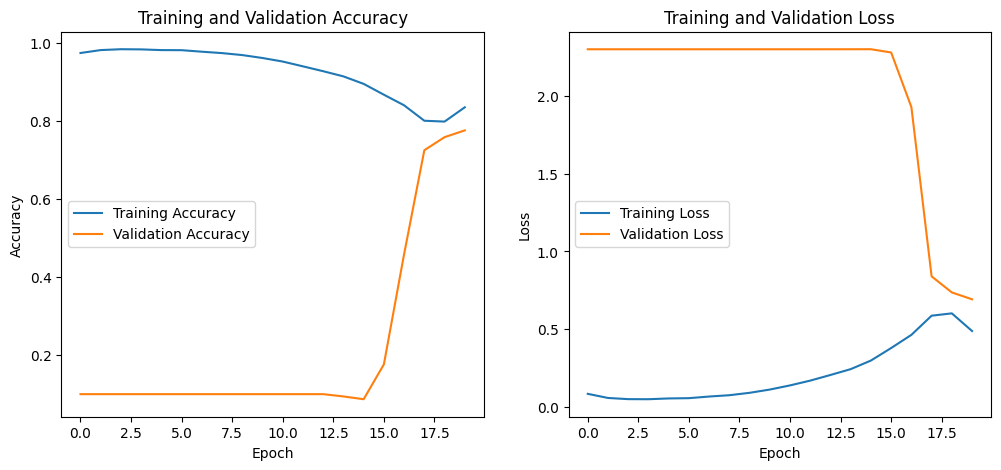

In [23]:
import matplotlib.pyplot as plt

# 학습 및 검증 정확도 시각화
plt.figure(figsize=(12, 5))

# 정확도 그래프
plt.subplot(1, 2, 1)
plt.plot(history_exp21.history['accuracy'], label='Training Accuracy')
plt.plot(history_exp21.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# 손실 그래프
plt.subplot(1, 2, 2)
plt.plot(history_exp21.history['loss'], label='Training Loss')
plt.plot(history_exp21.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.show()

## 2-2. (32, 16)

In [24]:
dataset_size = x_train.shape[0]
batch_size = 30
epochs = 20

total_iteration= int(epochs * (dataset_size / batch_size))

In [25]:
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Flatten, Dense, Dropout, InputLayer
import tensorflow as tf

# 새로운 레이어를 추가하기 위한 레이어 리스트 초기화
new_layers = []

# Dense 레이어 카운터
dense_layer_count = 0

# VGG 모델의 각 레이어 순회
for layer in best_vgg16.layers:
    if isinstance(layer, InputLayer):
        continue
    if isinstance(layer, Conv2D):
        # Conv2D 레이어를 ConvLoRALayer로 대체
        conv_lora_layer = ConvLoRALayer00_cdn2(original_conv_layer=layer, rank=32, alpha=32, total_iteration = total_iteration, trainable=True)
        new_layers.append(conv_lora_layer)
    elif isinstance(layer, Dense):
        dense_layer_count += 1
        # 첫 번째와 두 번째 Dense 레이어에만 LoraLayer 적용
        if dense_layer_count in [1, 2]:
            dense_lora_layer = LoraLayer(original_layer=layer, rank=16, alpha=32, total_iteration=total_iteration, trainable=True)
            new_layers.append(dense_lora_layer)
        else:
            new_layers.append(layer)  # 그대로 유지함
    else:
        # 다른 유형의 레이어는 그대로 유지
        new_layers.append(layer)

# 새로운 입력 텐서 생성
input_tensor = best_vgg16.input

# 새로운 모델 구성
x = input_tensor
for layer in new_layers:
    x = layer(x)

# 새로운 모델 생성
exp22_lora_vgg16 = Model(inputs=input_tensor, outputs=x)

In [26]:
from tensorflow.keras.layers import Conv2D

# 새로 생성된 모델에서 Dense 레이어 중 LoRA가 적용되지 않은 레이어의 trainable을 False로 설정
for layer in exp22_lora_vgg16.layers:
    if isinstance(layer, Dense) and not isinstance(layer, LoraLayer):
        layer.trainable = False

In [27]:
exp22_lora_vgg16.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 32, 32, 3)]       0         
                                                                 
 block1_conv1 (ConvLoRALaye  (None, 32, 32, 64)        21090     
 r00_cdn2)                                                       
                                                                 
 block1_conv2 (ConvLoRALaye  (None, 32, 32, 64)        73794     
 r00_cdn2)                                                       
                                                                 
 block1_pool (MaxPooling2D)  (None, 16, 16, 64)        0         
                                                                 
 block2_conv1 (ConvLoRALaye  (None, 16, 16, 128)       129154    
 r00_cdn2)                                                       
                                                           

In [28]:
import numpy as np

#모델의 각 레이어를 순회하며 파라미터 수를 계산
for layer in exp22_lora_vgg16.layers:
    trainable_count = np.sum([tf.size(w).numpy() for w in layer.trainable_weights])
    non_trainable_count = np.sum([tf.size(w).numpy() for w in layer.non_trainable_weights])

    print(f"Layer: {layer.name}")
    print(f"  Trainable parameters: {trainable_count}")
    print(f"  Non-trainable parameters: {non_trainable_count}")

Layer: input_3
  Trainable parameters: 0.0
  Non-trainable parameters: 0.0
Layer: block1_conv1
  Trainable parameters: 19296
  Non-trainable parameters: 1794
Layer: block1_conv2
  Trainable parameters: 36864
  Non-trainable parameters: 36930
Layer: block1_pool
  Trainable parameters: 0.0
  Non-trainable parameters: 0.0
Layer: block2_conv1
  Trainable parameters: 55296
  Non-trainable parameters: 73858
Layer: block2_conv2
  Trainable parameters: 73728
  Non-trainable parameters: 147586
Layer: block2_pool
  Trainable parameters: 0.0
  Non-trainable parameters: 0.0
Layer: block3_conv1
  Trainable parameters: 110592
  Non-trainable parameters: 295170
Layer: block3_conv2
  Trainable parameters: 147456
  Non-trainable parameters: 590082
Layer: block3_conv3
  Trainable parameters: 147456
  Non-trainable parameters: 590082
Layer: block3_pool
  Trainable parameters: 0.0
  Non-trainable parameters: 0.0
Layer: block4_conv1
  Trainable parameters: 221184
  Non-trainable parameters: 1180162
Layer: 

In [29]:
lora_layers = []  # lora 레이어들을 저장할 리스트

for layer in exp22_lora_vgg16.layers:
    if isinstance(layer, LoraLayer) or isinstance(layer, ConvLoRALayer00_cdn2):
        lora_layers.append(layer)

In [30]:
from tensorflow import keras

class PrintCurrentStepCallback(keras.callbacks.Callback):
    def __init__(self, lora_layers):
        super().__init__()
        self.lora_layers = lora_layers

    def on_epoch_end(self, epoch, logs=None):
        print()
        for i, lora_layer in enumerate(self.lora_layers):
            current_step = lora_layer.current_step.value()
            decay_factor = lora_layer.decay_factor.value()
            print(f"End of epoch {epoch + 1}, LoraLayer {i}: {current_step} Step")
            print(f"End of epoch {epoch + 1}, LoraLayer {i}: Decay factor: {decay_factor}")

class TestCallback(keras.callbacks.Callback):
    def __init__(self, test_data):
        self.test_data = test_data

    def on_epoch_end(self, epoch, logs={}):
        x, y = self.test_data
        loss, acc = self.model.evaluate(x, y, verbose=0)
        print('\nTesting loss: {}, acc: {}\n'.format(loss, acc))

In [31]:
# 콜백 생성 시 lora_layers 딕셔너리의 값만 사용
print_step_callback = PrintCurrentStepCallback(lora_layers)

In [32]:
from tensorflow.keras.optimizers import Adam

# 모델 컴파일
exp22_lora_vgg16.compile(optimizer=Adam(learning_rate=0.00005),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

### 학습

In [33]:
history_exp22 = exp22_lora_vgg16.fit(x_train, y_train, batch_size=30, epochs=20, validation_data=(x_test, y_test), callbacks=[print_step_callback, TestCallback((x_test, y_test))] )

Epoch 1/20
1666/1667 [============================>.] - ETA: 0s - loss: 0.0803 - accuracy: 0.9740
End of epoch 1, LoraLayer 0: 1667 Step
End of epoch 1, LoraLayer 0: Decay factor: 1.0
End of epoch 1, LoraLayer 1: 1667 Step
End of epoch 1, LoraLayer 1: Decay factor: 1.0
End of epoch 1, LoraLayer 2: 1667 Step
End of epoch 1, LoraLayer 2: Decay factor: 1.0
End of epoch 1, LoraLayer 3: 1667 Step
End of epoch 1, LoraLayer 3: Decay factor: 1.0
End of epoch 1, LoraLayer 4: 1667 Step
End of epoch 1, LoraLayer 4: Decay factor: 1.0
End of epoch 1, LoraLayer 5: 1667 Step
End of epoch 1, LoraLayer 5: Decay factor: 1.0
End of epoch 1, LoraLayer 6: 1667 Step
End of epoch 1, LoraLayer 6: Decay factor: 1.0
End of epoch 1, LoraLayer 7: 1667 Step
End of epoch 1, LoraLayer 7: Decay factor: 1.0
End of epoch 1, LoraLayer 8: 1667 Step
End of epoch 1, LoraLayer 8: Decay factor: 1.0
End of epoch 1, LoraLayer 9: 1667 Step
End of epoch 1, LoraLayer 9: Decay factor: 1.0
End of epoch 1, LoraLayer 10: 1667 Step
En

In [34]:
# 평가
exp22_lora_vgg16.evaluate(x_test, y_test)

313/313 [==============================] - 3s 10ms/step - loss: 0.7154 - accuracy: 0.7712


[0.7153621315956116, 0.7712000012397766]

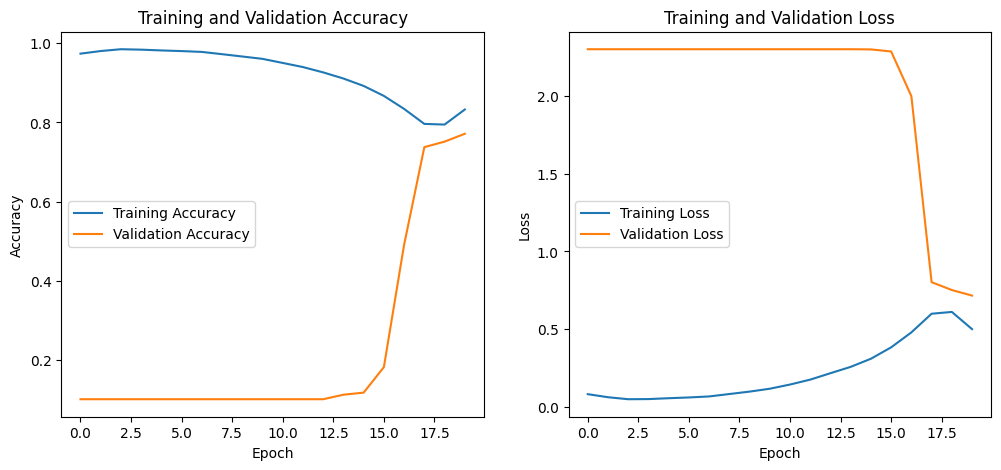

In [35]:
import matplotlib.pyplot as plt

# 학습 및 검증 정확도 시각화
plt.figure(figsize=(12, 5))

# 정확도 그래프
plt.subplot(1, 2, 1)
plt.plot(history_exp22.history['accuracy'], label='Training Accuracy')
plt.plot(history_exp22.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# 손실 그래프
plt.subplot(1, 2, 2)
plt.plot(history_exp22.history['loss'], label='Training Loss')
plt.plot(history_exp22.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.show()

## 2-3. (32, 64)

In [36]:
dataset_size = x_train.shape[0]
batch_size = 30
epochs = 20

total_iteration= int(epochs * (dataset_size / batch_size))

In [37]:
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Flatten, Dense, Dropout, InputLayer
import tensorflow as tf

# 새로운 레이어를 추가하기 위한 레이어 리스트 초기화
new_layers = []

# Dense 레이어 카운터
dense_layer_count = 0

# VGG 모델의 각 레이어 순회
for layer in best_vgg16.layers:
    if isinstance(layer, InputLayer):
        continue
    if isinstance(layer, Conv2D):
        # Conv2D 레이어를 ConvLoRALayer로 대체
        conv_lora_layer = ConvLoRALayer00_cdn2(original_conv_layer=layer, rank=32, alpha=32, total_iteration = total_iteration, trainable=True)
        new_layers.append(conv_lora_layer)
    elif isinstance(layer, Dense):
        dense_layer_count += 1
        # 첫 번째와 두 번째 Dense 레이어에만 LoraLayer 적용
        if dense_layer_count in [1, 2]:
            dense_lora_layer = LoraLayer(original_layer=layer, rank=64, alpha=32, total_iteration=total_iteration, trainable=True)
            new_layers.append(dense_lora_layer)
        else:
            new_layers.append(layer)  # 그대로 유지함
    else:
        # 다른 유형의 레이어는 그대로 유지
        new_layers.append(layer)

# 새로운 입력 텐서 생성
input_tensor = best_vgg16.input

# 새로운 모델 구성
x = input_tensor
for layer in new_layers:
    x = layer(x)

# 새로운 모델 생성
exp23_lora_vgg16 = Model(inputs=input_tensor, outputs=x)

In [38]:
from tensorflow.keras.layers import Conv2D

# 새로 생성된 모델에서 Dense 레이어 중 LoRA가 적용되지 않은 레이어의 trainable을 False로 설정
for layer in exp23_lora_vgg16.layers:
    if isinstance(layer, Dense) and not isinstance(layer, LoraLayer):
        layer.trainable = False

In [39]:
exp23_lora_vgg16.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 32, 32, 3)]       0         
                                                                 
 block1_conv1 (ConvLoRALaye  (None, 32, 32, 64)        21090     
 r00_cdn2)                                                       
                                                                 
 block1_conv2 (ConvLoRALaye  (None, 32, 32, 64)        73794     
 r00_cdn2)                                                       
                                                                 
 block1_pool (MaxPooling2D)  (None, 16, 16, 64)        0         
                                                                 
 block2_conv1 (ConvLoRALaye  (None, 16, 16, 128)       129154    
 r00_cdn2)                                                       
                                                           

In [40]:
import numpy as np

#모델의 각 레이어를 순회하며 파라미터 수를 계산
for layer in exp23_lora_vgg16.layers:
    trainable_count = np.sum([tf.size(w).numpy() for w in layer.trainable_weights])
    non_trainable_count = np.sum([tf.size(w).numpy() for w in layer.non_trainable_weights])

    print(f"Layer: {layer.name}")
    print(f"  Trainable parameters: {trainable_count}")
    print(f"  Non-trainable parameters: {non_trainable_count}")

Layer: input_3
  Trainable parameters: 0.0
  Non-trainable parameters: 0.0
Layer: block1_conv1
  Trainable parameters: 19296
  Non-trainable parameters: 1794
Layer: block1_conv2
  Trainable parameters: 36864
  Non-trainable parameters: 36930
Layer: block1_pool
  Trainable parameters: 0.0
  Non-trainable parameters: 0.0
Layer: block2_conv1
  Trainable parameters: 55296
  Non-trainable parameters: 73858
Layer: block2_conv2
  Trainable parameters: 73728
  Non-trainable parameters: 147586
Layer: block2_pool
  Trainable parameters: 0.0
  Non-trainable parameters: 0.0
Layer: block3_conv1
  Trainable parameters: 110592
  Non-trainable parameters: 295170
Layer: block3_conv2
  Trainable parameters: 147456
  Non-trainable parameters: 590082
Layer: block3_conv3
  Trainable parameters: 147456
  Non-trainable parameters: 590082
Layer: block3_pool
  Trainable parameters: 0.0
  Non-trainable parameters: 0.0
Layer: block4_conv1
  Trainable parameters: 221184
  Non-trainable parameters: 1180162
Layer: 

In [41]:
lora_layers = []  # lora 레이어들을 저장할 리스트

for layer in exp23_lora_vgg16.layers:
    if isinstance(layer, LoraLayer) or isinstance(layer, ConvLoRALayer00_cdn2):
        lora_layers.append(layer)

In [42]:
from tensorflow import keras

class PrintCurrentStepCallback(keras.callbacks.Callback):
    def __init__(self, lora_layers):
        super().__init__()
        self.lora_layers = lora_layers

    def on_epoch_end(self, epoch, logs=None):
        print()
        for i, lora_layer in enumerate(self.lora_layers):
            current_step = lora_layer.current_step.value()
            decay_factor = lora_layer.decay_factor.value()
            print(f"End of epoch {epoch + 1}, LoraLayer {i}: {current_step} Step")
            print(f"End of epoch {epoch + 1}, LoraLayer {i}: Decay factor: {decay_factor}")

class TestCallback(keras.callbacks.Callback):
    def __init__(self, test_data):
        self.test_data = test_data

    def on_epoch_end(self, epoch, logs={}):
        x, y = self.test_data
        loss, acc = self.model.evaluate(x, y, verbose=0)
        print('\nTesting loss: {}, acc: {}\n'.format(loss, acc))

In [43]:
# 콜백 생성 시 lora_layers 딕셔너리의 값만 사용
print_step_callback = PrintCurrentStepCallback(lora_layers)

In [44]:
from tensorflow.keras.optimizers import Adam

# 모델 컴파일
exp23_lora_vgg16.compile(optimizer=Adam(learning_rate=0.00005),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

### 학습

In [45]:
history_exp23 = exp23_lora_vgg16.fit(x_train, y_train, batch_size=30, epochs=20, validation_data=(x_test, y_test), callbacks=[print_step_callback, TestCallback((x_test, y_test))] )

Epoch 1/20
1666/1667 [============================>.] - ETA: 0s - loss: 0.0790 - accuracy: 0.9753
End of epoch 1, LoraLayer 0: 1667 Step
End of epoch 1, LoraLayer 0: Decay factor: 1.0
End of epoch 1, LoraLayer 1: 1667 Step
End of epoch 1, LoraLayer 1: Decay factor: 1.0
End of epoch 1, LoraLayer 2: 1667 Step
End of epoch 1, LoraLayer 2: Decay factor: 1.0
End of epoch 1, LoraLayer 3: 1667 Step
End of epoch 1, LoraLayer 3: Decay factor: 1.0
End of epoch 1, LoraLayer 4: 1667 Step
End of epoch 1, LoraLayer 4: Decay factor: 1.0
End of epoch 1, LoraLayer 5: 1667 Step
End of epoch 1, LoraLayer 5: Decay factor: 1.0
End of epoch 1, LoraLayer 6: 1667 Step
End of epoch 1, LoraLayer 6: Decay factor: 1.0
End of epoch 1, LoraLayer 7: 1667 Step
End of epoch 1, LoraLayer 7: Decay factor: 1.0
End of epoch 1, LoraLayer 8: 1667 Step
End of epoch 1, LoraLayer 8: Decay factor: 1.0
End of epoch 1, LoraLayer 9: 1667 Step
End of epoch 1, LoraLayer 9: Decay factor: 1.0
End of epoch 1, LoraLayer 10: 1667 Step
En

In [46]:
# 평가
exp23_lora_vgg16.evaluate(x_test, y_test)

313/313 [==============================] - 6s 20ms/step - loss: 0.7659 - accuracy: 0.7545


[0.7658989429473877, 0.7544999718666077]

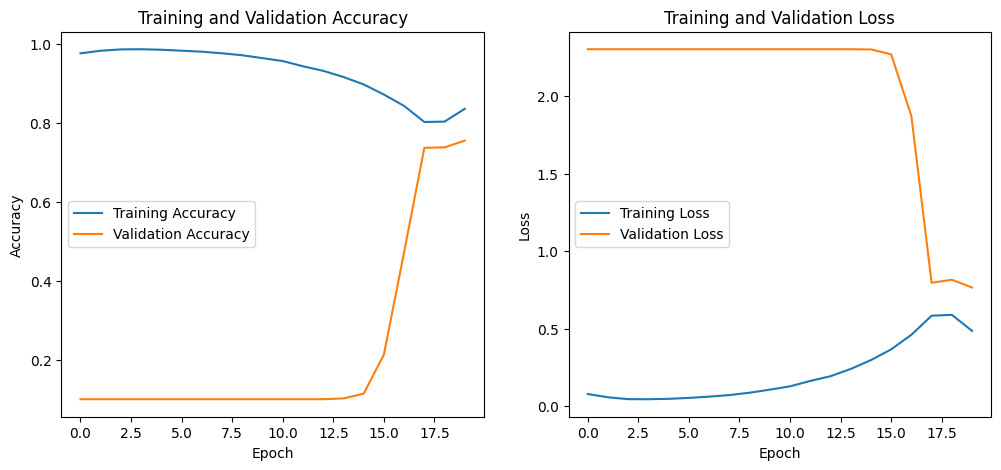

In [47]:
import matplotlib.pyplot as plt

# 학습 및 검증 정확도 시각화
plt.figure(figsize=(12, 5))

# 정확도 그래프
plt.subplot(1, 2, 1)
plt.plot(history_exp23.history['accuracy'], label='Training Accuracy')
plt.plot(history_exp23.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# 손실 그래프
plt.subplot(1, 2, 2)
plt.plot(history_exp23.history['loss'], label='Training Loss')
plt.plot(history_exp23.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.show()

## 2-4. (16, 16)

In [48]:
dataset_size = x_train.shape[0]
batch_size = 30
epochs = 20

total_iteration= int(epochs * (dataset_size / batch_size))

In [49]:
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Flatten, Dense, Dropout, InputLayer
import tensorflow as tf

# 새로운 레이어를 추가하기 위한 레이어 리스트 초기화
new_layers = []

# Dense 레이어 카운터
dense_layer_count = 0

# VGG 모델의 각 레이어 순회
for layer in best_vgg16.layers:
    if isinstance(layer, InputLayer):
        continue
    if isinstance(layer, Conv2D):
        # Conv2D 레이어를 ConvLoRALayer로 대체
        conv_lora_layer = ConvLoRALayer00_cdn2(original_conv_layer=layer, rank=16, alpha=32, total_iteration = total_iteration, trainable=True)
        new_layers.append(conv_lora_layer)
    elif isinstance(layer, Dense):
        dense_layer_count += 1
        # 첫 번째와 두 번째 Dense 레이어에만 LoraLayer 적용
        if dense_layer_count in [1, 2]:
            dense_lora_layer = LoraLayer(original_layer=layer, rank=16, alpha=32, total_iteration=total_iteration, trainable=True)
            new_layers.append(dense_lora_layer)
        else:
            new_layers.append(layer)  # 그대로 유지함
    else:
        # 다른 유형의 레이어는 그대로 유지
        new_layers.append(layer)

# 새로운 입력 텐서 생성
input_tensor = best_vgg16.input

# 새로운 모델 구성
x = input_tensor
for layer in new_layers:
    x = layer(x)

# 새로운 모델 생성
exp24_lora_vgg16 = Model(inputs=input_tensor, outputs=x)

In [50]:
from tensorflow.keras.layers import Conv2D

# 새로 생성된 모델에서 Dense 레이어 중 LoRA가 적용되지 않은 레이어의 trainable을 False로 설정
for layer in exp24_lora_vgg16.layers:
    if isinstance(layer, Dense) and not isinstance(layer, LoraLayer):
        layer.trainable = False

In [51]:
exp24_lora_vgg16.summary()

Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 32, 32, 3)]       0         
                                                                 
 block1_conv1 (ConvLoRALaye  (None, 32, 32, 64)        11442     
 r00_cdn2)                                                       
                                                                 
 block1_conv2 (ConvLoRALaye  (None, 32, 32, 64)        55362     
 r00_cdn2)                                                       
                                                                 
 block1_pool (MaxPooling2D)  (None, 16, 16, 64)        0         
                                                                 
 block2_conv1 (ConvLoRALaye  (None, 16, 16, 128)       101506    
 r00_cdn2)                                                       
                                                           

In [52]:
import numpy as np

#모델의 각 레이어를 순회하며 파라미터 수를 계산
for layer in exp24_lora_vgg16.layers:
    trainable_count = np.sum([tf.size(w).numpy() for w in layer.trainable_weights])
    non_trainable_count = np.sum([tf.size(w).numpy() for w in layer.non_trainable_weights])

    print(f"Layer: {layer.name}")
    print(f"  Trainable parameters: {trainable_count}")
    print(f"  Non-trainable parameters: {non_trainable_count}")

Layer: input_3
  Trainable parameters: 0.0
  Non-trainable parameters: 0.0
Layer: block1_conv1
  Trainable parameters: 9648
  Non-trainable parameters: 1794
Layer: block1_conv2
  Trainable parameters: 18432
  Non-trainable parameters: 36930
Layer: block1_pool
  Trainable parameters: 0.0
  Non-trainable parameters: 0.0
Layer: block2_conv1
  Trainable parameters: 27648
  Non-trainable parameters: 73858
Layer: block2_conv2
  Trainable parameters: 36864
  Non-trainable parameters: 147586
Layer: block2_pool
  Trainable parameters: 0.0
  Non-trainable parameters: 0.0
Layer: block3_conv1
  Trainable parameters: 55296
  Non-trainable parameters: 295170
Layer: block3_conv2
  Trainable parameters: 73728
  Non-trainable parameters: 590082
Layer: block3_conv3
  Trainable parameters: 73728
  Non-trainable parameters: 590082
Layer: block3_pool
  Trainable parameters: 0.0
  Non-trainable parameters: 0.0
Layer: block4_conv1
  Trainable parameters: 110592
  Non-trainable parameters: 1180162
Layer: bloc

In [53]:
lora_layers = []  # lora 레이어들을 저장할 리스트

for layer in exp24_lora_vgg16.layers:
    if isinstance(layer, LoraLayer) or isinstance(layer, ConvLoRALayer00_cdn2):
        lora_layers.append(layer)

In [54]:
from tensorflow import keras

class PrintCurrentStepCallback(keras.callbacks.Callback):
    def __init__(self, lora_layers):
        super().__init__()
        self.lora_layers = lora_layers

    def on_epoch_end(self, epoch, logs=None):
        print()
        for i, lora_layer in enumerate(self.lora_layers):
            current_step = lora_layer.current_step.value()
            decay_factor = lora_layer.decay_factor.value()
            print(f"End of epoch {epoch + 1}, LoraLayer {i}: {current_step} Step")
            print(f"End of epoch {epoch + 1}, LoraLayer {i}: Decay factor: {decay_factor}")

class TestCallback(keras.callbacks.Callback):
    def __init__(self, test_data):
        self.test_data = test_data

    def on_epoch_end(self, epoch, logs={}):
        x, y = self.test_data
        loss, acc = self.model.evaluate(x, y, verbose=0)
        print('\nTesting loss: {}, acc: {}\n'.format(loss, acc))

In [55]:
# 콜백 생성 시 lora_layers 딕셔너리의 값만 사용
print_step_callback = PrintCurrentStepCallback(lora_layers)

In [56]:
from tensorflow.keras.optimizers import Adam

# 모델 컴파일
exp24_lora_vgg16.compile(optimizer=Adam(learning_rate=0.00005),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

### 학습

In [57]:
history_exp24 = exp24_lora_vgg16.fit(x_train, y_train, batch_size=30, epochs=20, validation_data=(x_test, y_test), callbacks=[print_step_callback, TestCallback((x_test, y_test))] )

Epoch 1/20
1667/1667 [==============================] - ETA: 0s - loss: 0.1195 - accuracy: 0.9631
End of epoch 1, LoraLayer 0: 1667 Step
End of epoch 1, LoraLayer 0: Decay factor: 1.0
End of epoch 1, LoraLayer 1: 1667 Step
End of epoch 1, LoraLayer 1: Decay factor: 1.0
End of epoch 1, LoraLayer 2: 1667 Step
End of epoch 1, LoraLayer 2: Decay factor: 1.0
End of epoch 1, LoraLayer 3: 1667 Step
End of epoch 1, LoraLayer 3: Decay factor: 1.0
End of epoch 1, LoraLayer 4: 1667 Step
End of epoch 1, LoraLayer 4: Decay factor: 1.0
End of epoch 1, LoraLayer 5: 1667 Step
End of epoch 1, LoraLayer 5: Decay factor: 1.0
End of epoch 1, LoraLayer 6: 1667 Step
End of epoch 1, LoraLayer 6: Decay factor: 1.0
End of epoch 1, LoraLayer 7: 1667 Step
End of epoch 1, LoraLayer 7: Decay factor: 1.0
End of epoch 1, LoraLayer 8: 1667 Step
End of epoch 1, LoraLayer 8: Decay factor: 1.0
End of epoch 1, LoraLayer 9: 1667 Step
End of epoch 1, LoraLayer 9: Decay factor: 1.0
End of epoch 1, LoraLayer 10: 1667 Step
En

In [58]:
# 평가
exp24_lora_vgg16.evaluate(x_test, y_test)

313/313 [==============================] - 3s 9ms/step - loss: 0.7769 - accuracy: 0.7461


[0.7769083380699158, 0.7461000084877014]

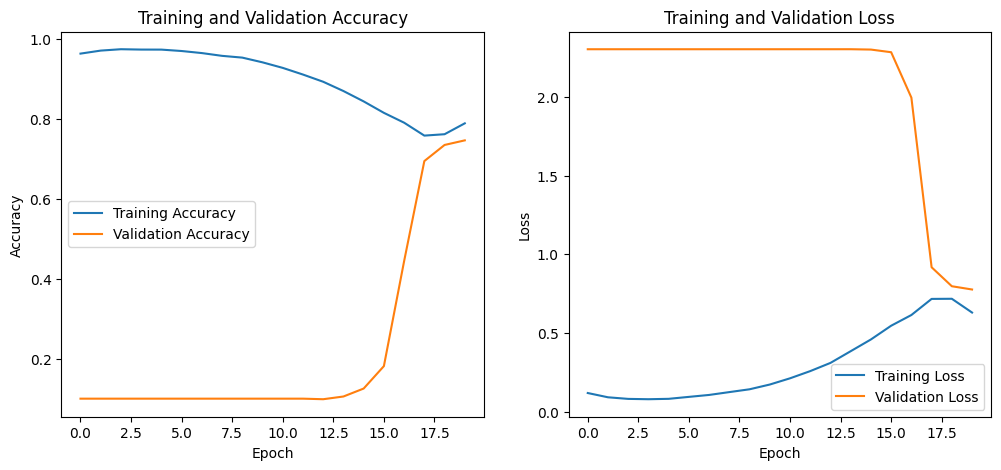

In [59]:
import matplotlib.pyplot as plt

# 학습 및 검증 정확도 시각화
plt.figure(figsize=(12, 5))

# 정확도 그래프
plt.subplot(1, 2, 1)
plt.plot(history_exp24.history['accuracy'], label='Training Accuracy')
plt.plot(history_exp24.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# 손실 그래프
plt.subplot(1, 2, 2)
plt.plot(history_exp24.history['loss'], label='Training Loss')
plt.plot(history_exp24.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.show()

## 2-5. (16, 32)

In [60]:
dataset_size = x_train.shape[0]
batch_size = 30
epochs = 20

total_iteration= int(epochs * (dataset_size / batch_size))

In [61]:
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Flatten, Dense, Dropout, InputLayer
import tensorflow as tf

# 새로운 레이어를 추가하기 위한 레이어 리스트 초기화
new_layers = []

# Dense 레이어 카운터
dense_layer_count = 0

# VGG 모델의 각 레이어 순회
for layer in best_vgg16.layers:
    if isinstance(layer, InputLayer):
        continue
    if isinstance(layer, Conv2D):
        # Conv2D 레이어를 ConvLoRALayer로 대체
        conv_lora_layer = ConvLoRALayer00_cdn2(original_conv_layer=layer, rank=16, alpha=32, total_iteration = total_iteration, trainable=True)
        new_layers.append(conv_lora_layer)
    elif isinstance(layer, Dense):
        dense_layer_count += 1
        # 첫 번째와 두 번째 Dense 레이어에만 LoraLayer 적용
        if dense_layer_count in [1, 2]:
            dense_lora_layer = LoraLayer(original_layer=layer, rank=32, alpha=32, total_iteration=total_iteration, trainable=True)
            new_layers.append(dense_lora_layer)
        else:
            new_layers.append(layer)  # 그대로 유지함
    else:
        # 다른 유형의 레이어는 그대로 유지
        new_layers.append(layer)

# 새로운 입력 텐서 생성
input_tensor = best_vgg16.input

# 새로운 모델 구성
x = input_tensor
for layer in new_layers:
    x = layer(x)

# 새로운 모델 생성
exp25_lora_vgg16 = Model(inputs=input_tensor, outputs=x)

In [62]:
from tensorflow.keras.layers import Conv2D

# 새로 생성된 모델에서 Dense 레이어 중 LoRA가 적용되지 않은 레이어의 trainable을 False로 설정
for layer in exp25_lora_vgg16.layers:
    if isinstance(layer, Dense) and not isinstance(layer, LoraLayer):
        layer.trainable = False

In [63]:
exp25_lora_vgg16.summary()

Model: "model_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 32, 32, 3)]       0         
                                                                 
 block1_conv1 (ConvLoRALaye  (None, 32, 32, 64)        11442     
 r00_cdn2)                                                       
                                                                 
 block1_conv2 (ConvLoRALaye  (None, 32, 32, 64)        55362     
 r00_cdn2)                                                       
                                                                 
 block1_pool (MaxPooling2D)  (None, 16, 16, 64)        0         
                                                                 
 block2_conv1 (ConvLoRALaye  (None, 16, 16, 128)       101506    
 r00_cdn2)                                                       
                                                           

In [64]:
import numpy as np

#모델의 각 레이어를 순회하며 파라미터 수를 계산
for layer in exp25_lora_vgg16.layers:
    trainable_count = np.sum([tf.size(w).numpy() for w in layer.trainable_weights])
    non_trainable_count = np.sum([tf.size(w).numpy() for w in layer.non_trainable_weights])

    print(f"Layer: {layer.name}")
    print(f"  Trainable parameters: {trainable_count}")
    print(f"  Non-trainable parameters: {non_trainable_count}")

Layer: input_3
  Trainable parameters: 0.0
  Non-trainable parameters: 0.0
Layer: block1_conv1
  Trainable parameters: 9648
  Non-trainable parameters: 1794
Layer: block1_conv2
  Trainable parameters: 18432
  Non-trainable parameters: 36930
Layer: block1_pool
  Trainable parameters: 0.0
  Non-trainable parameters: 0.0
Layer: block2_conv1
  Trainable parameters: 27648
  Non-trainable parameters: 73858
Layer: block2_conv2
  Trainable parameters: 36864
  Non-trainable parameters: 147586
Layer: block2_pool
  Trainable parameters: 0.0
  Non-trainable parameters: 0.0
Layer: block3_conv1
  Trainable parameters: 55296
  Non-trainable parameters: 295170
Layer: block3_conv2
  Trainable parameters: 73728
  Non-trainable parameters: 590082
Layer: block3_conv3
  Trainable parameters: 73728
  Non-trainable parameters: 590082
Layer: block3_pool
  Trainable parameters: 0.0
  Non-trainable parameters: 0.0
Layer: block4_conv1
  Trainable parameters: 110592
  Non-trainable parameters: 1180162
Layer: bloc

In [65]:
lora_layers = []  # lora 레이어들을 저장할 리스트

for layer in exp25_lora_vgg16.layers:
    if isinstance(layer, LoraLayer) or isinstance(layer, ConvLoRALayer00_cdn2):
        lora_layers.append(layer)

In [66]:
from tensorflow import keras

class PrintCurrentStepCallback(keras.callbacks.Callback):
    def __init__(self, lora_layers):
        super().__init__()
        self.lora_layers = lora_layers

    def on_epoch_end(self, epoch, logs=None):
        print()
        for i, lora_layer in enumerate(self.lora_layers):
            current_step = lora_layer.current_step.value()
            decay_factor = lora_layer.decay_factor.value()
            print(f"End of epoch {epoch + 1}, LoraLayer {i}: {current_step} Step")
            print(f"End of epoch {epoch + 1}, LoraLayer {i}: Decay factor: {decay_factor}")

class TestCallback(keras.callbacks.Callback):
    def __init__(self, test_data):
        self.test_data = test_data

    def on_epoch_end(self, epoch, logs={}):
        x, y = self.test_data
        loss, acc = self.model.evaluate(x, y, verbose=0)
        print('\nTesting loss: {}, acc: {}\n'.format(loss, acc))

In [67]:
# 콜백 생성 시 lora_layers 딕셔너리의 값만 사용
print_step_callback = PrintCurrentStepCallback(lora_layers)

In [68]:
from tensorflow.keras.optimizers import Adam

# 모델 컴파일
exp25_lora_vgg16.compile(optimizer=Adam(learning_rate=0.00005),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

### 학습

In [69]:
history_exp25 = exp25_lora_vgg16.fit(x_train, y_train, batch_size=30, epochs=20, validation_data=(x_test, y_test), callbacks=[print_step_callback, TestCallback((x_test, y_test))] )

Epoch 1/20
1666/1667 [============================>.] - ETA: 0s - loss: 0.1140 - accuracy: 0.9640
End of epoch 1, LoraLayer 0: 1667 Step
End of epoch 1, LoraLayer 0: Decay factor: 1.0
End of epoch 1, LoraLayer 1: 1667 Step
End of epoch 1, LoraLayer 1: Decay factor: 1.0
End of epoch 1, LoraLayer 2: 1667 Step
End of epoch 1, LoraLayer 2: Decay factor: 1.0
End of epoch 1, LoraLayer 3: 1667 Step
End of epoch 1, LoraLayer 3: Decay factor: 1.0
End of epoch 1, LoraLayer 4: 1667 Step
End of epoch 1, LoraLayer 4: Decay factor: 1.0
End of epoch 1, LoraLayer 5: 1667 Step
End of epoch 1, LoraLayer 5: Decay factor: 1.0
End of epoch 1, LoraLayer 6: 1667 Step
End of epoch 1, LoraLayer 6: Decay factor: 1.0
End of epoch 1, LoraLayer 7: 1667 Step
End of epoch 1, LoraLayer 7: Decay factor: 1.0
End of epoch 1, LoraLayer 8: 1667 Step
End of epoch 1, LoraLayer 8: Decay factor: 1.0
End of epoch 1, LoraLayer 9: 1667 Step
End of epoch 1, LoraLayer 9: Decay factor: 1.0
End of epoch 1, LoraLayer 10: 1667 Step
En

In [70]:
# 평가
exp25_lora_vgg16.evaluate(x_test, y_test)

313/313 [==============================] - 3s 10ms/step - loss: 0.7383 - accuracy: 0.7606


[0.7383261322975159, 0.7605999708175659]

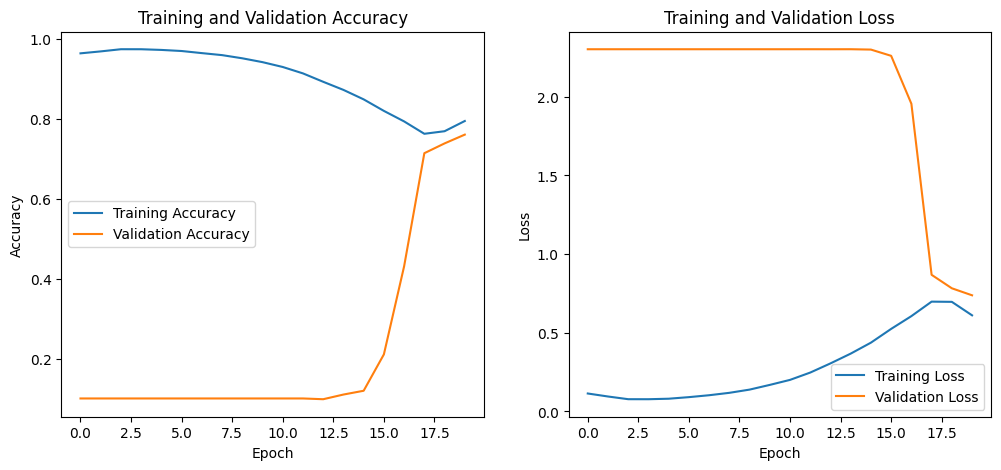

In [71]:
import matplotlib.pyplot as plt

# 학습 및 검증 정확도 시각화
plt.figure(figsize=(12, 5))

# 정확도 그래프
plt.subplot(1, 2, 1)
plt.plot(history_exp25.history['accuracy'], label='Training Accuracy')
plt.plot(history_exp25.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# 손실 그래프
plt.subplot(1, 2, 2)
plt.plot(history_exp25.history['loss'], label='Training Loss')
plt.plot(history_exp25.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.show()

## 2-6. (16, 64)

In [72]:
dataset_size = x_train.shape[0]
batch_size = 30
epochs = 20

total_iteration= int(epochs * (dataset_size / batch_size))

In [73]:
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Flatten, Dense, Dropout, InputLayer
import tensorflow as tf

# 새로운 레이어를 추가하기 위한 레이어 리스트 초기화
new_layers = []

# Dense 레이어 카운터
dense_layer_count = 0

# VGG 모델의 각 레이어 순회
for layer in best_vgg16.layers:
    if isinstance(layer, InputLayer):
        continue
    if isinstance(layer, Conv2D):
        # Conv2D 레이어를 ConvLoRALayer로 대체
        conv_lora_layer = ConvLoRALayer00_cdn2(original_conv_layer=layer, rank=16, alpha=32, total_iteration = total_iteration, trainable=True)
        new_layers.append(conv_lora_layer)
    elif isinstance(layer, Dense):
        dense_layer_count += 1
        # 첫 번째와 두 번째 Dense 레이어에만 LoraLayer 적용
        if dense_layer_count in [1, 2]:
            dense_lora_layer = LoraLayer(original_layer=layer, rank=64, alpha=32, total_iteration=total_iteration, trainable=True)
            new_layers.append(dense_lora_layer)
        else:
            new_layers.append(layer)  # 그대로 유지함
    else:
        # 다른 유형의 레이어는 그대로 유지
        new_layers.append(layer)

# 새로운 입력 텐서 생성
input_tensor = best_vgg16.input

# 새로운 모델 구성
x = input_tensor
for layer in new_layers:
    x = layer(x)

# 새로운 모델 생성
exp26_lora_vgg16 = Model(inputs=input_tensor, outputs=x)

In [74]:
from tensorflow.keras.layers import Conv2D

# 새로 생성된 모델에서 Dense 레이어 중 LoRA가 적용되지 않은 레이어의 trainable을 False로 설정
for layer in exp26_lora_vgg16.layers:
    if isinstance(layer, Dense) and not isinstance(layer, LoraLayer):
        layer.trainable = False

In [75]:
exp26_lora_vgg16.summary()

Model: "model_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 32, 32, 3)]       0         
                                                                 
 block1_conv1 (ConvLoRALaye  (None, 32, 32, 64)        11442     
 r00_cdn2)                                                       
                                                                 
 block1_conv2 (ConvLoRALaye  (None, 32, 32, 64)        55362     
 r00_cdn2)                                                       
                                                                 
 block1_pool (MaxPooling2D)  (None, 16, 16, 64)        0         
                                                                 
 block2_conv1 (ConvLoRALaye  (None, 16, 16, 128)       101506    
 r00_cdn2)                                                       
                                                           

In [76]:
import numpy as np

#모델의 각 레이어를 순회하며 파라미터 수를 계산
for layer in exp26_lora_vgg16.layers:
    trainable_count = np.sum([tf.size(w).numpy() for w in layer.trainable_weights])
    non_trainable_count = np.sum([tf.size(w).numpy() for w in layer.non_trainable_weights])

    print(f"Layer: {layer.name}")
    print(f"  Trainable parameters: {trainable_count}")
    print(f"  Non-trainable parameters: {non_trainable_count}")

Layer: input_3
  Trainable parameters: 0.0
  Non-trainable parameters: 0.0
Layer: block1_conv1
  Trainable parameters: 9648
  Non-trainable parameters: 1794
Layer: block1_conv2
  Trainable parameters: 18432
  Non-trainable parameters: 36930
Layer: block1_pool
  Trainable parameters: 0.0
  Non-trainable parameters: 0.0
Layer: block2_conv1
  Trainable parameters: 27648
  Non-trainable parameters: 73858
Layer: block2_conv2
  Trainable parameters: 36864
  Non-trainable parameters: 147586
Layer: block2_pool
  Trainable parameters: 0.0
  Non-trainable parameters: 0.0
Layer: block3_conv1
  Trainable parameters: 55296
  Non-trainable parameters: 295170
Layer: block3_conv2
  Trainable parameters: 73728
  Non-trainable parameters: 590082
Layer: block3_conv3
  Trainable parameters: 73728
  Non-trainable parameters: 590082
Layer: block3_pool
  Trainable parameters: 0.0
  Non-trainable parameters: 0.0
Layer: block4_conv1
  Trainable parameters: 110592
  Non-trainable parameters: 1180162
Layer: bloc

In [77]:
lora_layers = []  # lora 레이어들을 저장할 리스트

for layer in exp26_lora_vgg16.layers:
    if isinstance(layer, LoraLayer) or isinstance(layer, ConvLoRALayer00_cdn2):
        lora_layers.append(layer)

In [78]:
from tensorflow import keras

class PrintCurrentStepCallback(keras.callbacks.Callback):
    def __init__(self, lora_layers):
        super().__init__()
        self.lora_layers = lora_layers

    def on_epoch_end(self, epoch, logs=None):
        print()
        for i, lora_layer in enumerate(self.lora_layers):
            current_step = lora_layer.current_step.value()
            decay_factor = lora_layer.decay_factor.value()
            print(f"End of epoch {epoch + 1}, LoraLayer {i}: {current_step} Step")
            print(f"End of epoch {epoch + 1}, LoraLayer {i}: Decay factor: {decay_factor}")

class TestCallback(keras.callbacks.Callback):
    def __init__(self, test_data):
        self.test_data = test_data

    def on_epoch_end(self, epoch, logs={}):
        x, y = self.test_data
        loss, acc = self.model.evaluate(x, y, verbose=0)
        print('\nTesting loss: {}, acc: {}\n'.format(loss, acc))

In [79]:
# 콜백 생성 시 lora_layers 딕셔너리의 값만 사용
print_step_callback = PrintCurrentStepCallback(lora_layers)

In [80]:
from tensorflow.keras.optimizers import Adam

# 모델 컴파일
exp26_lora_vgg16.compile(optimizer=Adam(learning_rate=0.00005),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

### 학습

In [81]:
history_exp26 = exp26_lora_vgg16.fit(x_train, y_train, batch_size=30, epochs=20, validation_data=(x_test, y_test), callbacks=[print_step_callback, TestCallback((x_test, y_test))] )

Epoch 1/20
1667/1667 [==============================] - ETA: 0s - loss: 0.1146 - accuracy: 0.9632
End of epoch 1, LoraLayer 0: 1667 Step
End of epoch 1, LoraLayer 0: Decay factor: 1.0
End of epoch 1, LoraLayer 1: 1667 Step
End of epoch 1, LoraLayer 1: Decay factor: 1.0
End of epoch 1, LoraLayer 2: 1667 Step
End of epoch 1, LoraLayer 2: Decay factor: 1.0
End of epoch 1, LoraLayer 3: 1667 Step
End of epoch 1, LoraLayer 3: Decay factor: 1.0
End of epoch 1, LoraLayer 4: 1667 Step
End of epoch 1, LoraLayer 4: Decay factor: 1.0
End of epoch 1, LoraLayer 5: 1667 Step
End of epoch 1, LoraLayer 5: Decay factor: 1.0
End of epoch 1, LoraLayer 6: 1667 Step
End of epoch 1, LoraLayer 6: Decay factor: 1.0
End of epoch 1, LoraLayer 7: 1667 Step
End of epoch 1, LoraLayer 7: Decay factor: 1.0
End of epoch 1, LoraLayer 8: 1667 Step
End of epoch 1, LoraLayer 8: Decay factor: 1.0
End of epoch 1, LoraLayer 9: 1667 Step
End of epoch 1, LoraLayer 9: Decay factor: 1.0
End of epoch 1, LoraLayer 10: 1667 Step
En

In [82]:
# 평가
exp26_lora_vgg16.evaluate(x_test, y_test)

313/313 [==============================] - 3s 9ms/step - loss: 0.7440 - accuracy: 0.7519


[0.7439601421356201, 0.7519000172615051]

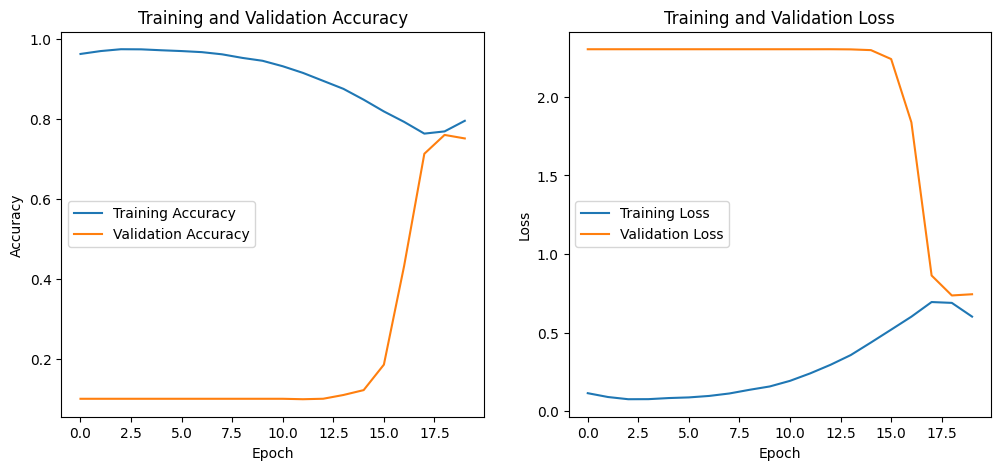

In [83]:
import matplotlib.pyplot as plt

# 학습 및 검증 정확도 시각화
plt.figure(figsize=(12, 5))

# 정확도 그래프
plt.subplot(1, 2, 1)
plt.plot(history_exp26.history['accuracy'], label='Training Accuracy')
plt.plot(history_exp26.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# 손실 그래프
plt.subplot(1, 2, 2)
plt.plot(history_exp26.history['loss'], label='Training Loss')
plt.plot(history_exp26.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.show()